In [45]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    color = color.cpu().numpy()
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [46]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader

# 使用Cora数据集
dataset = Planetoid(root='data/Planetoid', name='Cora')

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(GAT, self).__init__()
        # 第一层GAT，使用多头注意力机制
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        # 第二层GAT，将多头结果合并为输出
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        # 第一层GAT
        x = self.gat1(x, edge_index)
        x = F.elu(x)  # 激活函数
        x = F.dropout(x, p=0.6, training=self.training)
        # 第二层GAT
        x = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 模型、优化器、损失函数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(in_channels=dataset.num_node_features, hidden_channels=8, out_channels=dataset.num_classes, heads=8).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# 训练和测试
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits = model(data.x, data.edge_index)
    pred = logits.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        acc = (pred[mask] == data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

# 训练循环
for epoch in range(200):
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 000, Loss: 1.9725, Train Acc: 0.6000, Val Acc: 0.3760, Test Acc: 0.3910
Epoch: 001, Loss: 1.8129, Train Acc: 0.8429, Val Acc: 0.5680, Test Acc: 0.5800
Epoch: 002, Loss: 1.6137, Train Acc: 0.9143, Val Acc: 0.6800, Test Acc: 0.7220
Epoch: 003, Loss: 1.5044, Train Acc: 0.9500, Val Acc: 0.7380, Test Acc: 0.7690
Epoch: 004, Loss: 1.3979, Train Acc: 0.9500, Val Acc: 0.7760, Test Acc: 0.7870
Epoch: 005, Loss: 1.3169, Train Acc: 0.9571, Val Acc: 0.7760, Test Acc: 0.8100
Epoch: 006, Loss: 1.2325, Train Acc: 0.9571, Val Acc: 0.7760, Test Acc: 0.8100
Epoch: 007, Loss: 1.1302, Train Acc: 0.9571, Val Acc: 0.7760, Test Acc: 0.8120
Epoch: 008, Loss: 1.0962, Train Acc: 0.9786, Val Acc: 0.7840, Test Acc: 0.8080
Epoch: 009, Loss: 0.9543, Train Acc: 0.9786, Val Acc: 0.7820, Test Acc: 0.8120
Epoch: 010, Loss: 0.9003, Train Acc: 0.9786, Val Acc: 0.7860, Test Acc: 0.8090
Epoch: 011, Loss: 1.0254, Train Acc: 0.9857, Val Acc: 0.7880, Test Acc: 0.8080
Epoch: 012, Loss: 0.8151, Train Acc: 0.9929, Val Acc

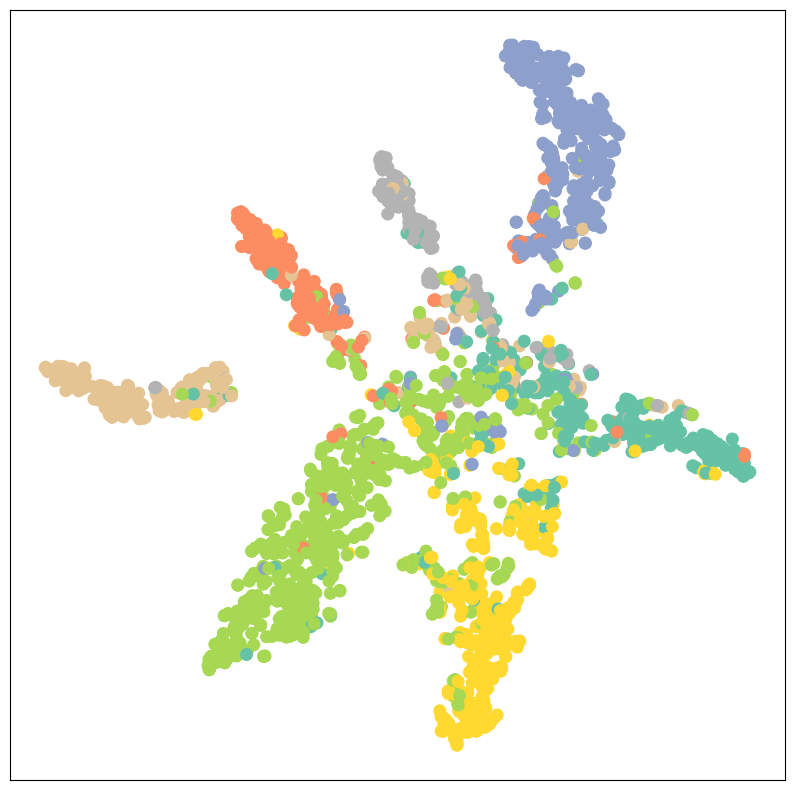

In [47]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)